# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = '../dataset/train/train.csv'
test_path = '../dataset/test/test_data.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [3]:
train.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [4]:
test.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,"{'word': 'MBC', 'start_idx': 7, 'end_idx': 9, ...","{'word': '탐사기획 스트레이트', 'start_idx': 12, 'end_i...",100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,"{'word': '프린세스 프링', 'start_idx': 7, 'end_idx':...","{'word': '공주', 'start_idx': 84, 'end_idx': 85,...",100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...","{'word': '경찰', 'start_idx': 121, 'end_idx': 12...","{'word': '1995년', 'start_idx': 31, 'end_idx': ...",100,wikipedia
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,"{'word': '세조', 'start_idx': 78, 'end_idx': 79,...","{'word': '정창손', 'start_idx': 0, 'end_idx': 2, ...",100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...","{'word': '민주당', 'start_idx': 3, 'end_idx': 5, ...","{'word': '권영진', 'start_idx': 16, 'end_idx': 18...",100,wikitree


## 전처리

subject_entity, object_entity 부분이 보기가 너무 어렵다.

In [5]:
train_subject_word = train.subject_entity.apply(lambda x : x.split("'")[3])
train_subject_type = train.subject_entity.apply(lambda x : x.split("'")[-2])
train_object_word = train.object_entity.apply(lambda x : x.split("'")[3])
train_object_type = train.object_entity.apply(lambda x : x.split("'")[-2])

train.insert(3,'object_type',train_object_type)
train.insert(3,'object_word',train_object_word)
train.insert(3,'subject_type',train_subject_type)
train.insert(3,'subject_word',train_subject_word)

train = train.drop(columns = ['subject_entity','object_entity'])


test_subject_word = test.subject_entity.apply(lambda x : x.split("'")[3])
test_subject_type = test.subject_entity.apply(lambda x : x.split("'")[-2])
test_object_word = test.object_entity.apply(lambda x : x.split("'")[3])
test_object_type = test.object_entity.apply(lambda x : x.split("'")[-2])

test.insert(3,'object_type',test_object_type)
test.insert(3,'object_word',test_object_word)
test.insert(3,'subject_type',test_subject_type)
test.insert(3,'subject_word',test_subject_word)

test = test.drop(columns = ['subject_entity','object_entity'])

In [6]:
train.head()

,id,sentence,subject_word,subject_type,object_word,object_type,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,ORG,조지 해리슨,PER,no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,ORG,대안신당,ORG,no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,ORG,한국프로축구연맹,ORG,org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,ORG,박정부,PER,org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,ORG,1967,DAT,no_relation,wikipedia


In [7]:
test.head()

,id,sentence,subject_word,subject_type,object_word,object_type,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,MBC,ORG,탐사기획 스트레이트,ORG,100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,프린세스 프링,PER,공주,POH,100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...",경찰,ORG,1995년,DAT,100,wikipedia
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,세조,PER,정창손,PER,100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...",민주당,ORG,권영진,PER,100,wikitree


## Check for missing values

In [8]:
print('train data')
print(train.isnull().sum())
print('-' * 50)
print('test data')
print(test.isnull().sum())

train data
id              0
sentence        0
subject_word    0
subject_type    0
object_word     0
object_type     0
label           0
source          0
dtype: int64
--------------------------------------------------
test data
id              0
sentence        0
subject_word    0
subject_type    0
object_word     0
object_type     0
label           0
source          0
dtype: int64


## Sentence Analysis

In [14]:
train.sentence.apply(len).describe()

count    32470.000000
mean        97.083954
std         47.939902
min         14.000000
25%         64.000000
50%         87.000000
75%        118.000000
max        455.000000
Name: sentence, dtype: float64

In [9]:
train.nunique()

id              32470
sentence        28803
subject_word    12052
subject_type        2
object_word     10224
object_type         6
label              30
source              3
dtype: int64

문장은 32470개인데 unique 문장은 28803

In [10]:
sentence_count = train.sentence.value_counts()
sentence_count.unique()

array([3, 2, 1])

In [11]:
pd.DataFrame(sentence_count).pivot_table(columns=['sentence'], aggfunc='size')

sentence
1    25380
2     3179
3      244
dtype: int64

In [12]:
train.sentence.value_counts()

도쿠가와 이에야스와 도쿠가와 히데타다가 20년에 걸쳐 안정시킨 막부를 이어받은 3대 쇼군 도쿠가와 이에미쓰는 중신들에게 유교 사상을 철저히 연구할 것을 지시했고, 한편으로 도쿠가와 미쓰쿠니 등은 《대일본사》(大日本史)와 같은 역사서를 편찬하는 등 문치(文治)를 지향하였으며, 이를 바탕으로 5대 쇼군 도쿠가와 이에쓰나 대에 에도 막부는 겐로쿠 호황이라고 부르는 최대의 전성기를 맞이했다.    3
왕은 대신 을지문덕을 시켜 그 진영에 나아가 거짓 항복케 하니 이것은 실상 그의 허실을 관찰하려 함이었는데 우중문이 먼저 받은 수제의 밀서에 "만약 왕이나 문덕이 오는 기회가 있거던 반드시 사로잡아야 한다" 하였으므로 문덕을 잡으려 하던 차 위무사 상서우승 유사룡이 굳이 말리어 중문은 못내 그 청을 들어 주었다.                                             3
2011년 12월 민주노동당과 국민참여당이 합당하여 통합진보당이 창당되자 통합진보당의 창당에 참여하고 통합진보당 원내대표가 되었다가 물러났다.                                                                                                                                             3
운구는 여영국 창원 시의원 등이 진행했고 이정미 대표와 심상정 의원 및 조문객들은 오열하였고, 부인 김지선 전 정의당 고문은 부축을 받으며 나가기도 했다.                                                                                                                                      3
또한 《삼국사기》에서는 비류왕을 구수왕의 아들이자 사반왕의 동생이라 기술하고도 같은 조의 다른 줄에는 생구로 살면서 명성을 얻었다는 구절이 나타난다.                             

## Token Analysis

In [15]:
train_token = train.sentence.apply(tokenizer.tokenize)

In [16]:
train_token_length = train_token.apply(len)

In [17]:
train_token_length.describe()

count    32470.000000
mean        50.958608
std         24.921942
min          7.000000
25%         34.000000
50%         46.000000
75%         62.000000
max        229.000000
Name: sentence, dtype: float64

In [ ]:
# train_token(sentence[UNK])analysis

## Subject, Object Analysis

In [18]:
train_subject_word = train.subject_word.value_counts()
train_subject_word.head(10)

민주당       144
화순군       107
고흥군        99
광주광역시      92
더불어민주당     92
여수시        82
목포시        80
문재인        80
영암군        75
포천시        73
Name: subject_word, dtype: int64

In [20]:
train_subject_word.describe()

count    12052.000000
mean         2.694159
std          5.103417
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        144.000000
Name: subject_word, dtype: float64

In [19]:
train_object_word = train.object_word.value_counts()
train_object_word.head(10)

대한민국      276
자유한국당     268
더불어민주당    236
문재인       135
UEFA      117
캐나다       115
스페인       113
김대중       113
정의당       111
골키퍼       110
Name: object_word, dtype: int64

In [21]:
train_object_word.describe()

count    10224.000000
mean         3.175861
std          8.563621
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        276.000000
Name: object_word, dtype: float64

In [22]:
train_subject_type = train.subject_type.value_counts()
train_subject_type.head(10)

PER    16786
ORG    15684
Name: subject_type, dtype: int64

In [23]:
train_object_type = train.object_type.value_counts()
train_object_type.head(10)

PER    9788
ORG    9346
POH    5113
DAT    4249
LOC    3561
NOH     413
Name: object_type, dtype: int64

## Label Analysis

In [24]:
train_labels = train.label.unique()
print(list(train_labels))
print(len(train_labels))

['no_relation', 'org:member_of', 'org:top_members/employees', 'org:alternate_names', 'per:date_of_birth', 'org:place_of_headquarters', 'per:employee_of', 'per:origin', 'per:title', 'org:members', 'per:schools_attended', 'per:colleagues', 'per:alternate_names', 'per:spouse', 'org:founded_by', 'org:political/religious_affiliation', 'per:children', 'org:founded', 'org:number_of_employees/members', 'per:place_of_birth', 'org:dissolved', 'per:parents', 'per:religion', 'per:date_of_death', 'per:place_of_residence', 'per:other_family', 'org:product', 'per:siblings', 'per:product', 'per:place_of_death']
30


In [25]:
train_label = train.label.value_counts()
train_label.head(10)

no_relation                  9534
org:top_members/employees    4284
per:employee_of              3573
per:title                    2103
org:member_of                1866
org:alternate_names          1320
per:origin                   1234
org:place_of_headquarters    1195
per:date_of_birth            1130
per:alternate_names          1001
Name: label, dtype: int64

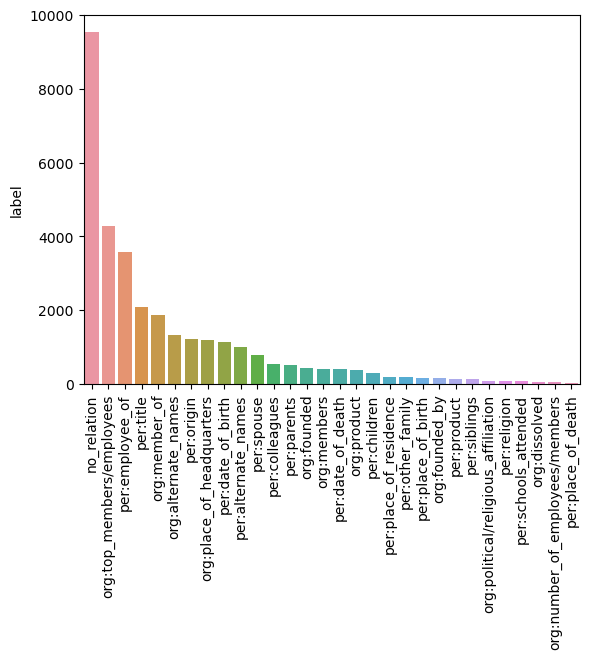

In [26]:
df_train_label = pd.DataFrame(train_label)
sns.barplot(x=df_train_label.index, y=df_train_label.label)
plt.xticks(rotation=90)
plt.show()

## Source

wikitree는 https://www.wikitree.co.kr/

wikipedia는 https://ko.wikipedia.org/

policy_briefing은 https://www.korea.kr/main.do


In [27]:
print('train data')
print(train.source.unique())
print('-' * 50)
print('test data')
print(test.source.unique())


train data
['wikipedia' 'wikitree' 'policy_briefing']
--------------------------------------------------
test data
['wikitree' 'wikipedia' 'policy_briefing']


source는 총 3가지 wikipedia', 'wikitree', 'policy_briefing' 이며 오 기입되어 있는 케이스는 없다.

In [28]:
print('train data')
print(train['source'].value_counts())
print('-' * 50)
print('test data')
print(test['source'].value_counts())

train data
wikipedia          21620
wikitree           10672
policy_briefing      178
Name: source, dtype: int64
--------------------------------------------------
test data
wikitree           4088
wikipedia          3621
policy_briefing      56
Name: source, dtype: int64


In [29]:
train_source = list(train['source'].value_counts())
test_source = list(test['source'].value_counts())

train_source_per = [i *100 / sum(train_source) for i in train_source]
test_source_per = [i *100 / sum(test_source) for i in test_source]

df_source = pd.DataFrame(data={'wikitree':[train_source_per[0],test_source_per[0]],'wikipedia':[train_source_per[1],test_source_per[1]],'policy_briefing':[train_source_per[2],test_source_per[2]], 'dataset_type':['train','test']})


In [30]:
df_source

,wikitree,wikipedia,policy_briefing,dataset_type
0,66.584540,32.867262,0.548198,train
1,52.646491,46.632325,0.721185,test
